# Lot-Level LPR Occupancy Model Training

This notebook trains a production-ready occupancy model for 183 parking lots using LPR (License Plate Reader) scan data as a proxy for parking activity.

## Model Overview

**Target Variable:** LPR scan count (hourly)
- Represents parking activity across all 183 lots
- 62 lots also have AMP occupancy data for validation
- 121 lots only have LPR data

**Features:**
- Temporal: hour, day_of_week, week_of_year, month, year
- Calendar: semester status, exam periods, breaks, days until semester start/end
- Weather: temperature, precipitation, conditions
- Lot-specific: lot number, zone, capacity
- Lag features: LPR scans from 1h, 2h, 3h, 24h, 168h ago

**Algorithm:** LightGBM Regressor
- Handles categorical features natively
- Fast training and prediction
- Strong performance on time-series data

## Data

Prepared in notebook 04:
- Training: FY20-FY24 (2020-08-10 to 2024-08-31)
- Validation: FY24-FY25 early (2024-08-31 to 2025-05-31)
- Test: FY25 late (2025-05-31 to 2025-10-31)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import pickle
from pathlib import Path
import json
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load Data

In [12]:
# Load train, validation, and test sets
data_dir = Path('../../data/processed')

print("Loading lot-level LPR data...")
train_df = pd.read_csv(data_dir / 'occupancy_lot_level_lpr_train.csv', parse_dates=['datetime'])
val_df = pd.read_csv(data_dir / 'occupancy_lot_level_lpr_val.csv', parse_dates=['datetime'])
test_df = pd.read_csv(data_dir / 'occupancy_lot_level_lpr_test.csv', parse_dates=['datetime'])

print(f"\nTrain: {len(train_df):,} records")
print(f"Val:   {len(val_df):,} records")
print(f"Test:  {len(test_df):,} records")

print(f"\nTrain date range: {train_df['datetime'].min()} to {train_df['datetime'].max()}")
print(f"Val date range:   {val_df['datetime'].min()} to {val_df['datetime'].max()}")
print(f"Test date range:  {test_df['datetime'].min()} to {test_df['datetime'].max()}")

Loading lot-level LPR data...

Train: 3,516,665 records
Val:   1,212,120 records
Test:  137,455 records

Train date range: 2022-07-01 00:00:00 to 2024-08-31 00:00:00
Val date range:   2024-08-31 01:00:00 to 2025-05-31 00:00:00
Test date range:  2025-05-31 01:00:00 to 2025-06-30 23:00:00


## Data Exploration

In [13]:
# Check for missing values
print("Missing values in training set:")
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])

# Check unique lots
print(f"\nUnique lots in training: {train_df['lot_number'].nunique()}")
print(f"Unique lots in validation: {val_df['lot_number'].nunique()}")
print(f"Unique lots in test: {test_df['lot_number'].nunique()}")

# Check target distribution
print(f"\nTarget (lpr_scans) statistics:")
print(train_df['lpr_scans'].describe())

Missing values in training set:
Zone    38018
dtype: int64

Unique lots in training: 185
Unique lots in validation: 185
Unique lots in test: 185

Target (lpr_scans) statistics:
count    3.516665e+06
mean     3.429209e-01
std      5.469782e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.760000e+02
Name: lpr_scans, dtype: float64


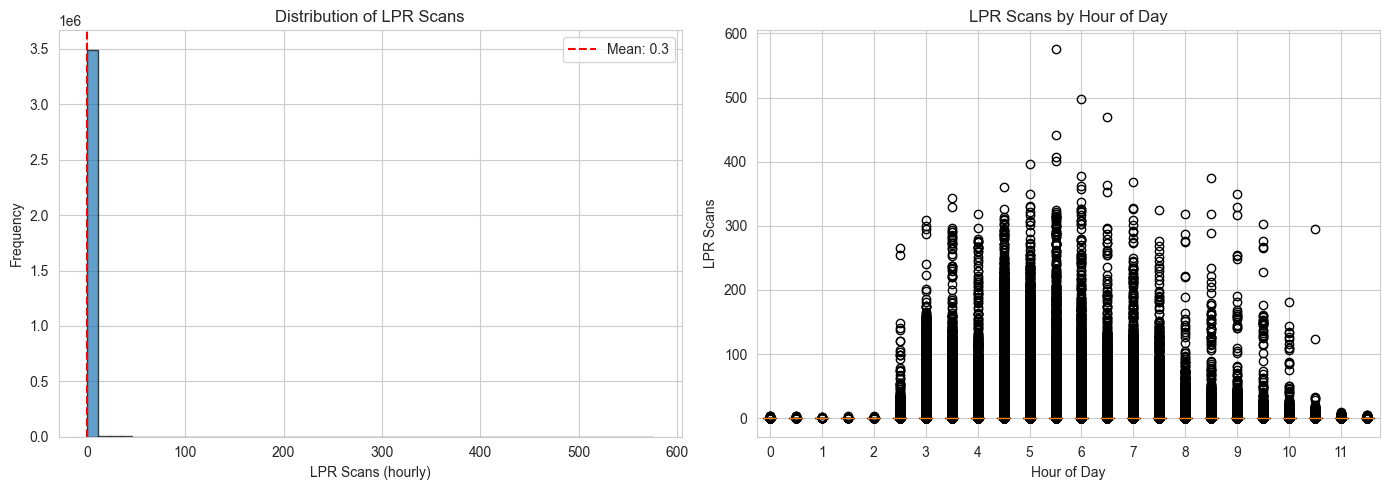

In [14]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(train_df['lpr_scans'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('LPR Scans (hourly)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of LPR Scans')
axes[0].axvline(train_df['lpr_scans'].mean(), color='red', linestyle='--', label=f"Mean: {train_df['lpr_scans'].mean():.1f}")
axes[0].legend()

# Box plot by hour
hourly_data = train_df.groupby('hour')['lpr_scans'].apply(list)
axes[1].boxplot([hourly_data[h] for h in range(24)], positions=range(24))
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('LPR Scans')
axes[1].set_title('LPR Scans by Hour of Day')
axes[1].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

## Feature Engineering

In [15]:
# Define features and target
feature_columns = [
    # Temporal features
    'hour', 'day_of_week', 'month', 'year', 'is_weekend',
    
    # Lot features
    'lot_number', 'Zone', 'capacity',
    
    # Calendar features
    'is_game_day', 'is_dead_week', 'is_finals_week', 'is_any_break',
    
    # Weather features
    'temp_mean_f', 'precipitation_inches', 'weather_category',
    'is_rainy', 'is_snowy', 'is_cold', 'is_hot',
    
    # Lag features
    'lpr_scans_lag_1h', 'lpr_scans_lag_2h', 'lpr_scans_lag_3h',
    'lpr_scans_lag_24h', 'lpr_scans_lag_168h'
]

target_column = 'lpr_scans'

# Categorical features for LightGBM
categorical_features = ['hour', 'day_of_week', 'month', 'lot_number', 'Zone', 'weather_category']

print(f"Total features: {len(feature_columns)}")
print(f"Categorical features: {len(categorical_features)}")

Total features: 24
Categorical features: 6


In [16]:
# Handle missing values in lag features
# Fill with 0 for missing lags (beginning of time series)
lag_cols = ['lpr_scans_lag_1h', 'lpr_scans_lag_2h', 'lpr_scans_lag_3h', 'lpr_scans_lag_24h', 'lpr_scans_lag_168h']

for col in lag_cols:
    if col in train_df.columns:
        train_df[col] = train_df[col].fillna(0)
        val_df[col] = val_df[col].fillna(0)
        test_df[col] = test_df[col].fillna(0)

# Handle missing weather data
weather_cols = ['temp_mean_f', 'precipitation_inches']
for col in weather_cols:
    if col in train_df.columns:
        train_median = train_df[col].median()
        train_df[col] = train_df[col].fillna(train_median)
        val_df[col] = val_df[col].fillna(train_median)
        test_df[col] = test_df[col].fillna(train_median)

if 'weather_category' in train_df.columns:
    train_df['weather_category'] = train_df['weather_category'].fillna('Clear')
    val_df['weather_category'] = val_df['weather_category'].fillna('Clear')
    test_df['weather_category'] = test_df['weather_category'].fillna('Clear')

print("Missing values handled.")

Missing values handled.


In [17]:
# Prepare feature matrices
X_train = train_df[feature_columns].copy()
y_train = train_df[target_column].copy()

X_val = val_df[feature_columns].copy()
y_val = val_df[target_column].copy()

X_test = test_df[feature_columns].copy()
y_test = test_df[target_column].copy()

# Convert categorical columns to category dtype for LightGBM
for col in categorical_features:
    if col in X_train.columns and X_train[col].dtype == 'object':
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')
        X_test[col] = X_test[col].astype('category')

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nData types:")
print(X_train.dtypes)

X_train shape: (3516665, 24)
X_val shape: (1212120, 24)
X_test shape: (137455, 24)

Data types:
hour                       int64
day_of_week                int64
month                      int64
year                       int64
is_weekend                 int64
lot_number                 int64
Zone                    category
capacity                 float64
is_game_day                int64
is_dead_week               int64
is_finals_week             int64
is_any_break               int64
temp_mean_f              float64
precipitation_inches     float64
weather_category        category
is_rainy                   int64
is_snowy                   int64
is_cold                    int64
is_hot                     int64
lpr_scans_lag_1h           int64
lpr_scans_lag_2h           int64
lpr_scans_lag_3h           int64
lpr_scans_lag_24h          int64
lpr_scans_lag_168h         int64
dtype: object


## Model Training

In [18]:
# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, reference=train_data)

print("LightGBM datasets created.")

LightGBM datasets created.


In [19]:
# Set hyperparameters
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

print("Hyperparameters:")
for key, value in params.items():
    print(f"  {key}: {value}")

Hyperparameters:
  objective: regression
  metric: mae
  boosting_type: gbdt
  num_leaves: 31
  learning_rate: 0.05
  feature_fraction: 0.8
  bagging_fraction: 0.8
  bagging_freq: 5
  verbose: -1
  random_state: 42


In [20]:
# Train model
print("Training LightGBM model...\n")

callbacks = [
    lgb.log_evaluation(period=100),
    lgb.early_stopping(stopping_rounds=50)
]

model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'val'],
    callbacks=callbacks
)

print(f"\nBest iteration: {model.best_iteration}")
print(f"Best validation MAE: {model.best_score['val']['l1']:.4f}")

Training LightGBM model...

Training until validation scores don't improve for 50 rounds
[100]	train's l1: 0.495853	val's l1: 0.633012
Early stopping, best iteration is:
[89]	train's l1: 0.498207	val's l1: 0.632694

Best iteration: 89
Best validation MAE: 0.6327


## Model Evaluation

In [21]:
# Make predictions
y_train_pred = model.predict(X_train, num_iteration=model.best_iteration)
y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Clip negative predictions to 0
y_train_pred = np.maximum(y_train_pred, 0)
y_val_pred = np.maximum(y_val_pred, 0)
y_test_pred = np.maximum(y_test_pred, 0)

print("Predictions generated.")

Predictions generated.


In [22]:
# Calculate metrics
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Set Performance:")
    print(f"  MAE:  {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²:   {r2:.4f}")
    
    return {'mae': mae, 'rmse': rmse, 'r2': r2}

train_metrics = evaluate_model(y_train, y_train_pred, "Train")
val_metrics = evaluate_model(y_val, y_val_pred, "Validation")
test_metrics = evaluate_model(y_test, y_test_pred, "Test")


Train Set Performance:
  MAE:  0.4982
  RMSE: 4.7704
  R²:   0.2394

Validation Set Performance:
  MAE:  0.6326
  RMSE: 6.0403
  R²:   0.1791

Test Set Performance:
  MAE:  0.4054
  RMSE: 3.8226
  R²:   0.0909


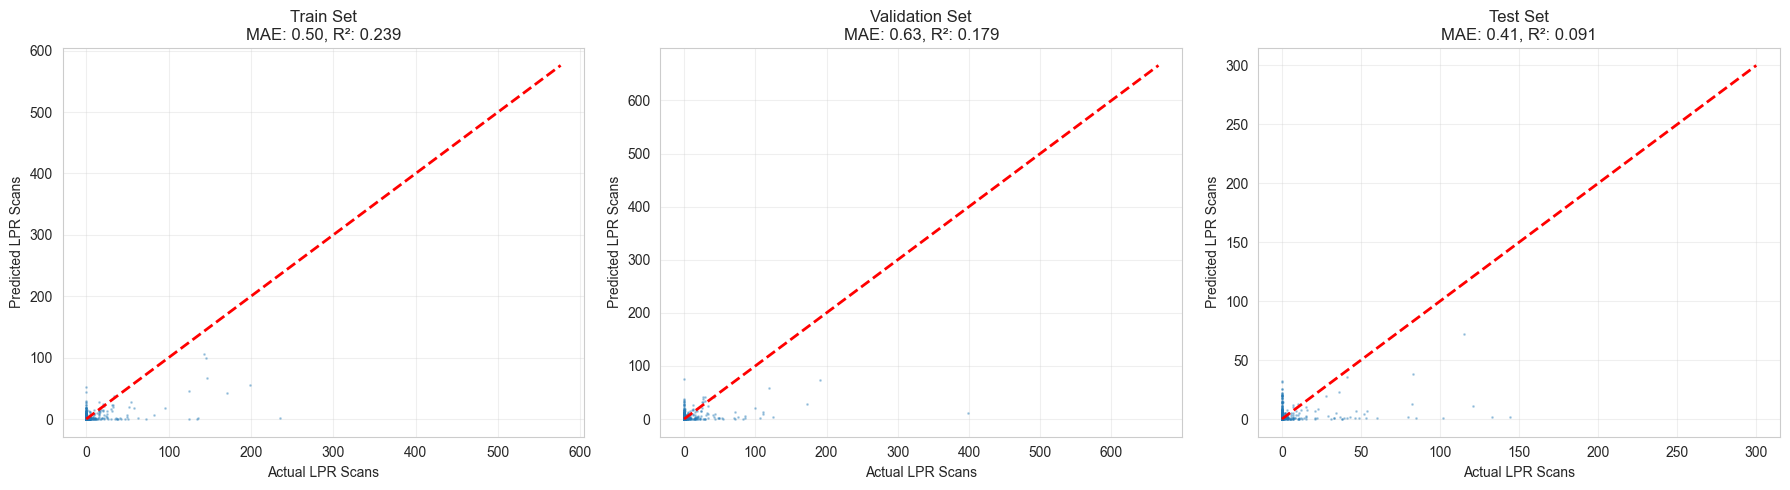

In [23]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = [
    (y_train, y_train_pred, "Train", train_metrics),
    (y_val, y_val_pred, "Validation", val_metrics),
    (y_test, y_test_pred, "Test", test_metrics)
]

for ax, (y_true, y_pred, name, metrics) in zip(axes, datasets):
    # Sample for visualization (too many points otherwise)
    sample_size = min(10000, len(y_true))
    indices = np.random.choice(len(y_true), sample_size, replace=False)
    
    ax.scatter(y_true.iloc[indices], y_pred[indices], alpha=0.3, s=1)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    ax.set_xlabel('Actual LPR Scans')
    ax.set_ylabel('Predicted LPR Scans')
    ax.set_title(f"{name} Set\nMAE: {metrics['mae']:.2f}, R²: {metrics['r2']:.3f}")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

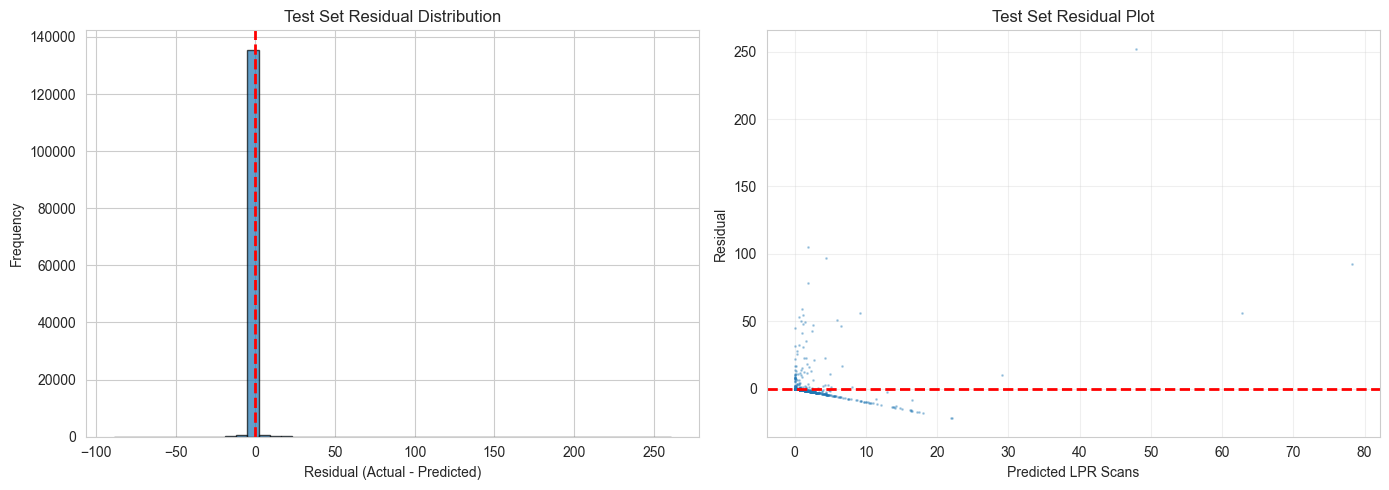

In [24]:
# Residual analysis
test_residuals = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual histogram
axes[0].hist(test_residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Residual (Actual - Predicted)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Test Set Residual Distribution')
axes[0].axvline(0, color='red', linestyle='--', lw=2)

# Residual scatter
sample_size = min(10000, len(test_residuals))
indices = np.random.choice(len(test_residuals), sample_size, replace=False)
axes[1].scatter(y_test_pred[indices], test_residuals.iloc[indices], alpha=0.3, s=1)
axes[1].axhline(0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted LPR Scans')
axes[1].set_ylabel('Residual')
axes[1].set_title('Test Set Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Feature Importance

In [25]:
# Get feature importance
importance = model.feature_importance(importance_type='gain')
feature_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': importance
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance_df.head(15))


Top 15 Most Important Features:
                 feature    importance
23    lpr_scans_lag_168h  5.250578e+07
22     lpr_scans_lag_24h  3.637943e+07
5             lot_number  3.574611e+07
0                   hour  2.123665e+07
19      lpr_scans_lag_1h  1.236150e+07
7               capacity  8.714055e+06
12           temp_mean_f  8.011080e+06
4             is_weekend  7.818829e+06
2                  month  7.661717e+06
1            day_of_week  5.327278e+06
20      lpr_scans_lag_2h  3.689022e+06
6                   Zone  3.252853e+06
13  precipitation_inches  3.141701e+06
11          is_any_break  2.916347e+06
3                   year  2.607630e+06


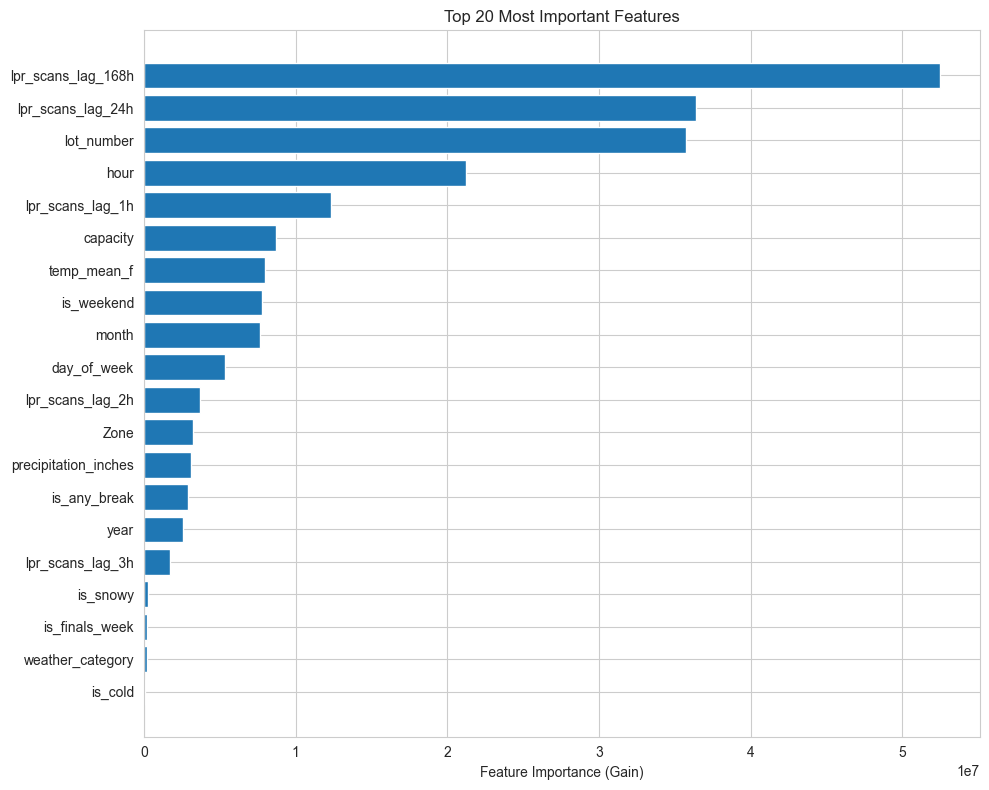

In [26]:
# Visualize feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Per-Lot Performance Analysis

In [27]:
# Analyze performance by lot
test_df['predicted_lpr_scans'] = y_test_pred

lot_performance = test_df.groupby('lot_number').apply(
    lambda x: pd.Series({
        'mae': mean_absolute_error(x['lpr_scans'], x['predicted_lpr_scans']),
        'rmse': np.sqrt(mean_squared_error(x['lpr_scans'], x['predicted_lpr_scans'])),
        'r2': r2_score(x['lpr_scans'], x['predicted_lpr_scans']),
        'mean_actual': x['lpr_scans'].mean(),
        'mean_predicted': x['predicted_lpr_scans'].mean(),
        'count': len(x)
    })
).reset_index()

print("\nTop 10 Best Performing Lots (by R²):")
print(lot_performance.nlargest(10, 'r2')[['lot_number', 'mae', 'rmse', 'r2', 'mean_actual']])

print("\nTop 10 Worst Performing Lots (by R²):")
print(lot_performance.nsmallest(10, 'r2')[['lot_number', 'mae', 'rmse', 'r2', 'mean_actual']])


Top 10 Best Performing Lots (by R²):
     lot_number       mae       rmse        r2  mean_actual
144         150  1.532999   3.309467  0.343868     1.729475
67           71  0.849400   1.409801  0.170356     0.831763
46           47  1.219349   4.418861  0.154879     0.703903
41           42  0.942288   4.150526  0.151778     0.671602
8             9  4.666091  20.073726  0.133217     2.518170
42           43  0.413362   3.485075  0.123585     0.324361
152         158  0.704671   3.164214  0.123332     0.511440
32           33  1.052556   5.844310  0.119863     0.917900
125         130  0.198934   0.924723  0.118616     0.127860
100         104  3.022385  13.559375  0.097057     1.619112

Top 10 Worst Performing Lots (by R²):
     lot_number       mae      rmse         r2  mean_actual
49           51  0.231193  0.350552 -90.427726     0.001346
174         182  0.415892  0.642191 -76.019706     0.005384
0             1  0.879216  1.350547  -7.226504     0.055182
75           79  0.0518

C:\Users\gudin\AppData\Local\Temp\ipykernel_44292\2544344935.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lot_performance = test_df.groupby('lot_number').apply(


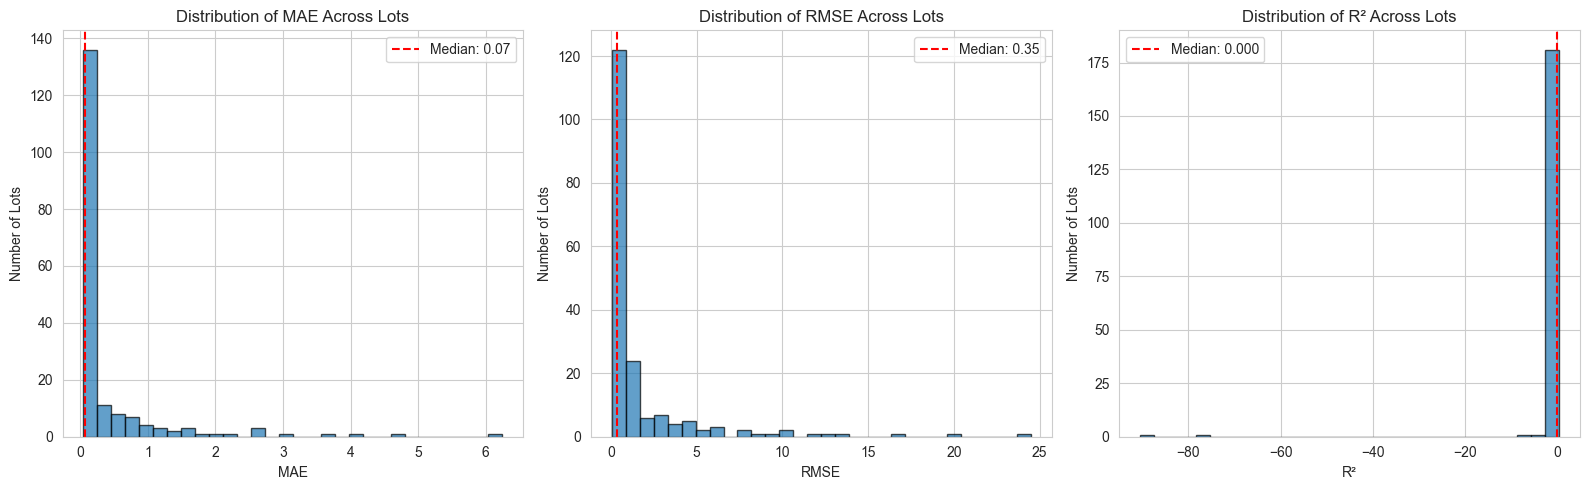

In [28]:
# Visualize lot performance distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].hist(lot_performance['mae'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('MAE')
axes[0].set_ylabel('Number of Lots')
axes[0].set_title('Distribution of MAE Across Lots')
axes[0].axvline(lot_performance['mae'].median(), color='red', linestyle='--', label=f"Median: {lot_performance['mae'].median():.2f}")
axes[0].legend()

axes[1].hist(lot_performance['rmse'], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('RMSE')
axes[1].set_ylabel('Number of Lots')
axes[1].set_title('Distribution of RMSE Across Lots')
axes[1].axvline(lot_performance['rmse'].median(), color='red', linestyle='--', label=f"Median: {lot_performance['rmse'].median():.2f}")
axes[1].legend()

axes[2].hist(lot_performance['r2'], bins=30, edgecolor='black', alpha=0.7)
axes[2].set_xlabel('R²')
axes[2].set_ylabel('Number of Lots')
axes[2].set_title('Distribution of R² Across Lots')
axes[2].axvline(lot_performance['r2'].median(), color='red', linestyle='--', label=f"Median: {lot_performance['r2'].median():.3f}")
axes[2].legend()

plt.tight_layout()
plt.show()

## Save Model and Metadata

In [29]:
# Save model
model_dir = Path('../../models')
model_dir.mkdir(exist_ok=True)

model_path = model_dir / 'occupancy_lot_level_lpr_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

print(f"Model saved to: {model_path}")

Model saved to: ..\..\models\occupancy_lot_level_lpr_model.pkl


In [30]:
# Save metadata
metadata = {
    'model_type': 'LightGBM with Lag Features (Lot-Level LPR)',
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'num_lots': int(train_df['lot_number'].nunique()),
    'performance': {
        'train_mae': float(train_metrics['mae']),
        'train_rmse': float(train_metrics['rmse']),
        'train_r2': float(train_metrics['r2']),
        'val_mae': float(val_metrics['mae']),
        'val_rmse': float(val_metrics['rmse']),
        'val_r2': float(val_metrics['r2']),
        'test_mae': float(test_metrics['mae']),
        'test_rmse': float(test_metrics['rmse']),
        'test_r2': float(test_metrics['r2'])
    },
    'features': {
        'total': len(feature_columns),
        'categorical': len(categorical_features),
        'lag_features': 5,
        'feature_list': feature_columns
    },
    'data_summary': {
        'train_records': len(train_df),
        'val_records': len(val_df),
        'test_records': len(test_df),
        'train_date_range': f"{train_df['datetime'].min()} to {train_df['datetime'].max()}",
        'val_date_range': f"{val_df['datetime'].min()} to {val_df['datetime'].max()}",
        'test_date_range': f"{test_df['datetime'].min()} to {test_df['datetime'].max()}"
    },
    'hyperparameters': params
}

metadata_path = model_dir / 'occupancy_lot_level_lpr_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)

print(f"Metadata saved to: {metadata_path}")

Metadata saved to: ..\..\models\occupancy_lot_level_lpr_metadata.json


In [31]:
# Save lot performance analysis
lot_performance_path = model_dir / 'lot_level_lpr_performance_by_lot.csv'
lot_performance.to_csv(lot_performance_path, index=False)

print(f"Lot performance analysis saved to: {lot_performance_path}")

Lot performance analysis saved to: ..\..\models\lot_level_lpr_performance_by_lot.csv


## Model Summary

This lot-level LPR model provides parking activity predictions for all 183 parking lots at WSU Pullman. The model uses hourly LPR scan counts as a proxy for parking demand and incorporates lag features to capture temporal patterns.
